In [1]:
import pyro
import pyro.contrib.gp as gp
from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import gpytorch
import torch

import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import ipywidgets
from ipywidgets import interact
import IPython
import time
# If in your browser the figures are not nicely vizualized, change the following line.
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (20, 8)

warnings.filterwarnings('ignore')


prior_c, svi_c, mcmc_c = sns.color_palette()[:3]
COLORS = {'Prior': prior_c, 'SVI': svi_c, 'MCMC': mcmc_c}

# Generate Data

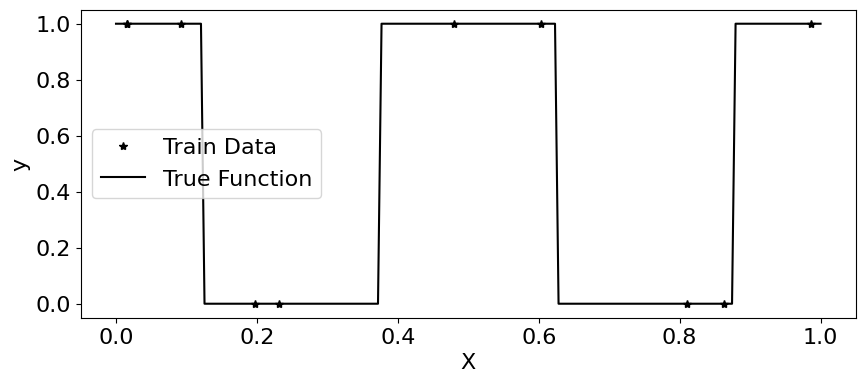

In [2]:
torch.manual_seed(13)
def true_f(x):
    return torch.sign(torch.cos(x * (4 * np.pi))).add(1).div(2)
num_samples = 1000
num_train = 10
num_test = 200

train_x = torch.rand(num_train)
train_y = true_f(train_x)

test_x = torch.linspace(0, 1, num_test)
test_y = true_f(test_x)
plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(train_x, train_y, 'k*', label='Train Data')
plt.plot(test_x, test_y, 'k-', label='True Function')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [3]:
def get_predictions(gp, test_x):
    with torch.no_grad():
        gp.eval()
        f_loc, f_var = gp(test_x, full_cov=False)
        f_std = f_var.sqrt() 
        
        mean = torch.sigmoid(f_loc)
        pred_labels = 0.5 * torch.ones_like(f_loc)
        pred_labels[mean >= 0.5 ] = 1
        pred_labels[mean <= 0.5 ] = 0
        
        lower, upper = torch.sigmoid(f_loc - f_std), torch.sigmoid(f_loc + f_std)
    return mean, lower, upper, pred_labels

def plot_gpc(gp, train_x, train_y, test_x, test_y, color="b", plot_true=True, ncol=2):
    mean, lower, upper, pred_labels = get_predictions(gp, test_x)
    if plot_true:
        plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data', markersize=16)
        plt.plot(test_x, test_y, 'k-', label='True Function')

    plt.plot(test_x.numpy(), pred_labels.numpy(), color, label='Prediction')
    plt.plot(test_x.numpy(), mean.numpy(), color=color, linestyle="dashed", label='Mean')
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), color=color, alpha=0.1)
    plt.xlim(0, 1)
    plt.ylim([-0.1, 1.2])
    plt.legend(loc='best', ncol=ncol)

def train_svi(gp, svi, num_steps):
    gp.train()
    for i in range(num_steps):
        try:
            svi.step()
        except RuntimeError:
            break

# Laplace Approximation of GP-posterior

In [4]:
def get_laplace_approx(train_x, train_y):
    gpc = gp.models.VariationalGP(
            train_x,
            train_y,
            kernel=gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor([0.1]), variance=torch.tensor([1.])),
            mean_function=gpytorch.means.ConstantMean(),
            likelihood=gp.likelihoods.Binary(),
            whiten=True,
            jitter=1e-1
    )
    delta_guide = AutoLaplaceApproximation(gpc.model) ### Laplace approximation
    svi = SVI(gpc.model, delta_guide, Adam({"lr": 1e-2}), loss=Trace_ELBO())
    return gpc, svi 

def svi_interact(num_points):
    start_train = time.time()
    torch.manual_seed(13)
    train_x = torch.rand(num_points)
    train_y = true_f(train_x)
    pyro.clear_param_store()
    gpc, svi = get_laplace_approx(train_x, train_y)

    def train_model(num_steps):
        train_svi(gpc, svi, num_steps)
        plot_model()

    def plot_model():
        plot_gpc(gpc, train_x, train_y, test_x, test_y, color="r")
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
        plt.close()
        button = ipywidgets.Button(description="Do 100 more steps")
        button.on_click(lambda b: train_model(num_steps=100))
        display(button)
        button_ = ipywidgets.Button(description="Do 1000 more steps")
        button_.on_click(lambda b: train_model(num_steps=1000))
        display(button_)
        
    train_model(200)
    print("train time",time.time()-start_train)

interact(svi_interact, num_points=ipywidgets.IntSlider(value=20, min=5, max=200, continuous_update=False));


interactive(children=(IntSlider(value=20, continuous_update=False, description='num_points', max=200, min=5), …

## Demo Guide:
First when you run this demo you can set the ***Cell/All output/toggle*** above for better visualization
#### some explanation
The classification task here can be understood as a bayesian logistic regression task with Laplace approximation. 
- num points: The number of training points which will be uniformly generate from 0 - 1
- Do 100/1000 more steps: Initialize with 200 steps training after number points change.
- SVI: more detail check on [tutoiral](https://docs.pyro.ai/en/stable/contrib.gp.html#module-pyro.contrib.gp.models.vgp). Stochastic variational inference. We train the model with GP and then infer with Laplace approximation

#### play around
- See how the prediction changes with more data points
- See how the uncertainty change in the area with more or less data.
- See how the uncertainty changes with more and more training steps

# Variational GP with Bernoulli Likelihood and Sigmoid Link function

$$f \sim \mathcal{N}(\mu, \sigma^2), \quad y \sim \mathcal{B} \left(\sigma(f) \right),$$
where $\sigma$ is the sigmoid function.

In [5]:
def get_variational_approx(train_x, train_y):
    gpc = gp.models.VariationalGP(
        train_x,
        train_y,
        kernel=gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor([0.1]), variance=torch.tensor([1.])),
        mean_function=gpytorch.means.ConstantMean(),
        likelihood=gp.likelihoods.Binary(),
        whiten=True,
        jitter=1e-1
    )

    svi = SVI(gpc.model, gpc.guide, Adam({"lr": 1e-2}), loss=Trace_ELBO())
    return gpc, svi 

def svi_interact(num_points):
    start_train = time.time()
    torch.manual_seed(13)
    train_x = torch.rand(num_points)
    train_y = true_f(train_x)
    
    pyro.clear_param_store()
    gpc, svi = get_variational_approx(train_x, train_y)

    def train_model(num_steps):
        train_svi(gpc, svi, num_steps)
        plot_model()
        
    def plot_model():
        plot_gpc(gpc, train_x, train_y, test_x, test_y, color="b")
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
        plt.close()
        button = ipywidgets.Button(description="Do 100 more steps")
        button.on_click(lambda b: train_model(num_steps=100))
        display(button)
        button_ = ipywidgets.Button(description="Do 1000 more steps")
        button_.on_click(lambda b: train_model(num_steps=1000))
        display(button_)

    train_model(200)
    print("train time",time.time()-start_train)

interact(svi_interact, num_points=ipywidgets.IntSlider(value=20, min=5, max=200, continuous_update=False));


interactive(children=(IntSlider(value=20, continuous_update=False, description='num_points', max=200, min=5), …

## Demo Guide:

#### some explanation
Compared with the above Laplace approximation. This demo use train the GP with Binary likelihood (Bernoulli distribution). As you can see using the Bernoulli distribution in variational inference cost more time than laplace distribution
- num points: The number of training points which will be uniformly generate from 0 - 1
- Do 100/1000 more steps: Initialize with 200 steps training after number points change.

#### play around
- See how the prediction changes with more data points
- See how the uncertainty change in the area with more or less data.
- See how the uncertainty changes with more and more training steps

# Compare Posteriors

In [6]:
def svi_interact(num_points, num_steps):
    torch.manual_seed(13)
    train_x = torch.rand(num_points)
    train_y = true_f(train_x)
    
    pyro.clear_param_store()
    gpc, svi = get_laplace_approx(train_x, train_y)
    train_svi(gpc, svi, num_steps)
    plot_gpc(gpc, train_x, train_y, test_x, test_y, color="r")
    
    pyro.clear_param_store()
    gpc, svi = get_variational_approx(train_x, train_y)
    train_svi(gpc, svi, num_steps)
    plot_gpc(gpc, train_x, train_y, test_x, test_y, color="b", plot_true=False, ncol=3)
    
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    plt.close()
interact(
    svi_interact, 
    num_points=ipywidgets.IntSlider(value=20, min=10, max=200, step=10, continuous_update=False),
    num_steps=ipywidgets.IntSlider(value=500, min=200, max=2000, step=100, continuous_update=False)
);


interactive(children=(IntSlider(value=20, continuous_update=False, description='num_points', max=200, min=10, …

## Demo Guide:

#### some explanation
This demo overlap the above two methods togther so that you can easily compare the difference.